In [1]:
# Loading necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas_profiling
%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\us61565\Desktop\Explainability\Framingham\framingham.csv')

In [3]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
# looking at stats
# pandas_profiling.ProfileReport(df)

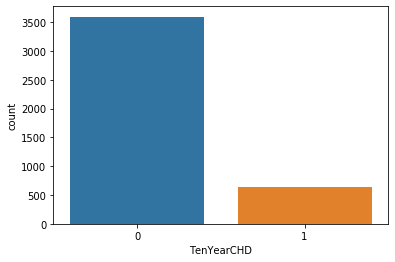

In [5]:
# Exploring the target variable
df['TenYearCHD'].value_counts(normalize = True)
sns.countplot(x='TenYearCHD',data=df)

0

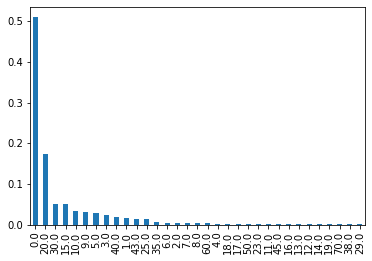

In [6]:
# Exploring cigsPerDay
df['cigsPerDay'].value_counts(normalize = True).plot(kind="bar")
df['cigsPerDay'][df['currentSmoker']==0].isna().sum() # Are there any NaNs for non-smokers?

In [7]:
# creating a boolean array of smokers
smoke = (df['currentSmoker']==1)
# applying mean to NaNs in cigsPerDay but using a set of smokers only
df.loc[smoke,'cigsPerDay'] = df.loc[smoke,'cigsPerDay'].fillna(df.loc[smoke,'cigsPerDay'].mean())
df['cigsPerDay'][df['currentSmoker']==1].mean()

18.35624394966117

In [8]:
# Filling out missing values
df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)

In [9]:
df.isna().sum() # are ther any NaNs left?

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

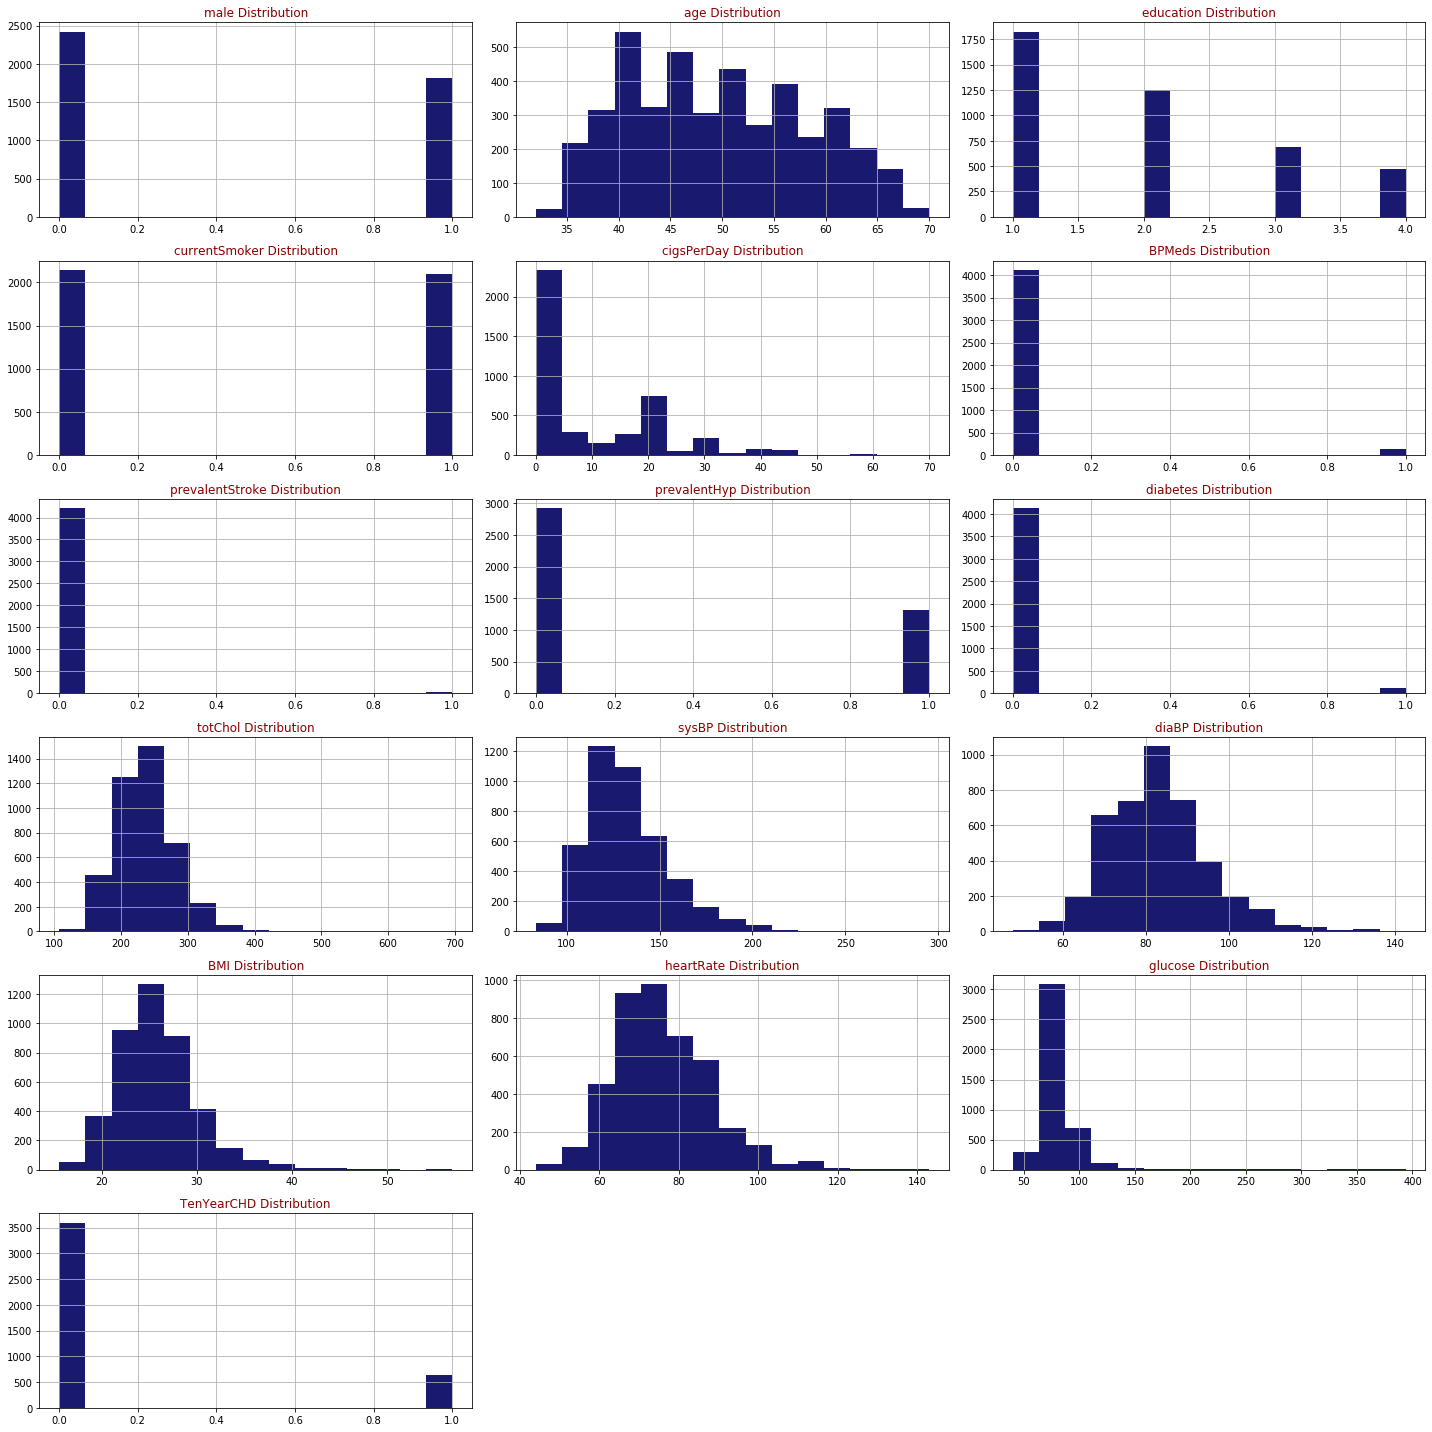

In [10]:
# A nice thing to have in front of the eyes: all histograms together
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=15,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,6,3)

### A quick baseline

In [11]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [12]:
features = df.iloc[:,:-1]
result = df.iloc[:,-1] # the last column is what we are about to forecast

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

([<matplotlib.axis.XTick at 0x1bc9ab70>,
 <a list of 15 Text xticklabel objects>)

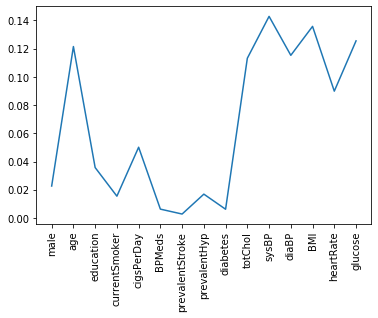

In [15]:
# what features are the most important?
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90)

In [16]:
# View a list of the features and their importance scores
list(zip(features, rf.feature_importances_))

[('male', 0.022614733109495078),
 ('age', 0.12149932664790082),
 ('education', 0.03571586055475766),
 ('currentSmoker', 0.015428708689577183),
 ('cigsPerDay', 0.05012566953303954),
 ('BPMeds', 0.006247855757263557),
 ('prevalentStroke', 0.002762901409702716),
 ('prevalentHyp', 0.01687101962474857),
 ('diabetes', 0.0061703883791000445),
 ('totChol', 0.11320176539763808),
 ('sysBP', 0.14289550270949286),
 ('diaBP', 0.115279381454193),
 ('BMI', 0.1357929482726004),
 ('heartRate', 0.08988053766188821),
 ('glucose', 0.12551340079860226)]

In [17]:
# Making predictions on unseen data
predictions_rf = rf.predict(X_test)

In [18]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       724
           1       0.38      0.06      0.11       124

    accuracy                           0.85       848
   macro avg       0.62      0.52      0.51       848
weighted avg       0.79      0.85      0.80       848



In [19]:
print(confusion_matrix(y_test, predictions_rf))

[[711  13]
 [116   8]]


In [20]:
accuracy_score(y_test, predictions_rf)

0.847877358490566

In [21]:
# Under ROC curve
prob_rf = rf.predict_proba(X_test)
prob_rf = [p[1] for p in prob_rf]
print(roc_auc_score(y_test, prob_rf))

0.7107077615398325


#### Feature selection using Random Forest

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [23]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.12
sfm = SelectFromModel(clf, threshold=0.12)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini', max_depth=2,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
                                                 warm_sta

In [25]:
feat_labels = list(features.columns.values) # creating a list with features' names
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

age
prevalentHyp
sysBP
glucose


Feature ranking:
1. feature 1 (0.242214)
2. feature 10 (0.200736)
3. feature 14 (0.152858)
4. feature 7 (0.139117)
5. feature 11 (0.105004)
6. feature 0 (0.034898)
7. feature 12 (0.034277)
8. feature 4 (0.022181)
9. feature 5 (0.016595)
10. feature 8 (0.015724)
11. feature 9 (0.014800)
12. feature 13 (0.009745)
13. feature 2 (0.007321)
14. feature 6 (0.004530)
15. feature 3 (0.000000)


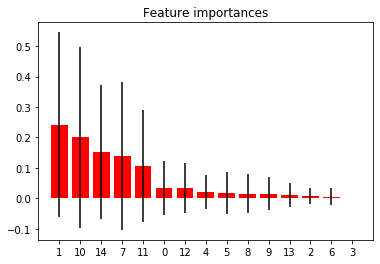

In [26]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [27]:
# with only imporant features. Can check X_important_train.shape[1]
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [28]:
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [29]:
predictions_y_4 = clf_important.predict(X_important_test)
print(classification_report(y_test, predictions_y_4))
print(confusion_matrix(y_test, predictions_y_4))
accuracy_score(y_test, predictions_y_4)
# Under ROC curve
prob_y_4 = clf_important.predict_proba(X_important_test)
prob_y_4 = [p[1] for p in prob_y_4]
print(roc_auc_score(y_test, prob_y_4))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       724
           1       0.27      0.10      0.14       124

    accuracy                           0.83       848
   macro avg       0.56      0.53      0.52       848
weighted avg       0.77      0.83      0.79       848

[[691  33]
 [112  12]]
0.6730306540723578


### Logistic regression 

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [31]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [32]:
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train_std, y_train)
predictions_y_2 = logmodel.predict(X_test_std)

In [33]:
print(classification_report(y_test, predictions_y_2))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.40      0.05      0.09       124

    accuracy                           0.85       848
   macro avg       0.63      0.52      0.50       848
weighted avg       0.79      0.85      0.80       848



In [34]:
print(confusion_matrix(y_test, predictions_y_2))

[[715   9]
 [118   6]]


In [35]:
accuracy_score(y_test, predictions_y_2)

0.8502358490566038

In [36]:
# Under ROC curve
prob_y_2 = logmodel.predict_proba(X_test_std)
prob_y_2 = [p[1] for p in prob_y_2]
print(roc_auc_score(y_test, prob_y_2))

0.7551015861700232


#### Adding class_weight='balanced'

In [37]:
logmodel = LogisticRegression(solver='liblinear', class_weight='balanced')
logmodel.fit(X_train_std, y_train)
predictions_y_3 = logmodel.predict(X_test_std)

In [38]:
# fewer Type II errors but less accurate 
print(classification_report(y_test, predictions_y_3))
print(confusion_matrix(y_test, predictions_y_3))
accuracy_score(y_test, predictions_y_3)
# Under ROC curve
prob_y_3 = logmodel.predict_proba(X_test_std)
prob_y_3 = [p[1] for p in prob_y_3]
print(roc_auc_score(y_test, prob_y_3))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       724
           1       0.28      0.73      0.40       124

    accuracy                           0.68       848
   macro avg       0.61      0.70      0.59       848
weighted avg       0.84      0.68      0.73       848

[[488 236]
 [ 34  90]]
0.7555360007128855


### Parameters choosing

In [39]:
from sklearn.model_selection import GridSearchCV
weights = np.linspace(0.03, 0.97, 55)

In [40]:
# gridsearch should be done on the big dataset, before it's split in train and test. Thus, normalizing features
scaler = StandardScaler()
features_std = scaler.fit_transform(features)

In [41]:
gsc = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='roc_auc',
    cv=3
)
grid_result = gsc.fit(features_std, result)

In [42]:
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.882962962962963, 1: 0.11703703703703705}}


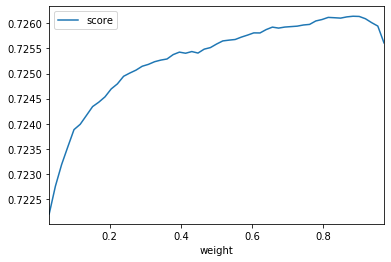

In [43]:
# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [44]:
# passing weights found above
rf_w = RandomForestClassifier(class_weight = {0:0.882962962962963, 1:0.11703703703703705})
rf_w.fit(X_train, y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.882962962962963,
                                     1: 0.11703703703703705},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [45]:
# Making predictions on unseen data
predictions_rf_w = rf_w.predict(X_test)

In [46]:
# a bit worse than with default parameters
print(classification_report(y_test, predictions_rf_w))
print(confusion_matrix(y_test, predictions_rf_w))
accuracy_score(y_test, predictions_rf_w)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       724
           1       0.19      0.04      0.07       124

    accuracy                           0.83       848
   macro avg       0.52      0.51      0.49       848
weighted avg       0.76      0.83      0.79       848

[[703  21]
 [119   5]]


0.8349056603773585

In [47]:
# Or to the logistic regression:
weights = {0 : '0.882962962962963', 1 : '0.11703703703703705'}
logmodel_auto_gridsearch = LogisticRegression(class_weight = weights, solver = 'liblinear')
logmodel_auto_gridsearch.fit(X_train_std, y_train)
predictions_std_auto_gridsearch = logmodel_auto_gridsearch.predict(X_test_std)

In [48]:
print(classification_report(y_test, predictions_std_auto_gridsearch))
print(confusion_matrix(y_test, predictions_std_auto_gridsearch))
accuracy_score(y_test, predictions_std_auto_gridsearch)
# Under ROC curve
prob_y_3_gridsearch = logmodel_auto_gridsearch.predict_proba(X_test_std)
prob_y_3_gridsearch= [p[1] for p in prob_y_3_gridsearch]
print(roc_auc_score(y_test, prob_y_3_gridsearch))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       724
           1       0.00      0.00      0.00       124

    accuracy                           0.85       848
   macro avg       0.43      0.50      0.46       848
weighted avg       0.73      0.85      0.79       848

[[724   0]
 [124   0]]
0.75598155409018


C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Upsampling/downsampling manually

In [49]:
from sklearn.utils import resample

In [50]:
df_minority = df[df.TenYearCHD==1]
df_majority = df[df.TenYearCHD==0]

In [51]:
df['TenYearCHD'].value_counts()

0    3596
1     644
Name: TenYearCHD, dtype: int64

In [52]:
# Upsample minority class
# sample with replacement to match majority class and get reproducible results
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=3596,    
                                 random_state=123) 
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.TenYearCHD.value_counts()

1    3596
0    3596
Name: TenYearCHD, dtype: int64

In [53]:
# Train/test, normalize the new data set
features_upsampled = df_upsampled.iloc[:,:-1]
result_upsampled = df_upsampled.iloc[:,-1]

X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(features_upsampled, result_upsampled, test_size = 0.2, random_state = 14)

X_train_std_upsampled = scaler.fit_transform(X_train_upsampled)
X_test_std_upsampled = scaler.fit_transform(X_test_upsampled)

In [54]:
# new log model for upsampled data
logmodel_upsampled = LogisticRegression(solver='liblinear')
logmodel_upsampled.fit(X_train_std_upsampled, y_train_upsampled)
predictions_y_2_upsampled = logmodel_upsampled.predict(X_test_std_upsampled)

In [55]:
# very poor results
print(classification_report(y_test_upsampled, predictions_y_2_upsampled))
print(confusion_matrix(y_test_upsampled, predictions_y_2_upsampled))
accuracy_score(y_test_upsampled, predictions_y_2_upsampled)
# Under ROC curve
prob_y_2_upsampled = logmodel_upsampled.predict_proba(X_test_std_upsampled)
prob_y_2_upsampled = [p[1] for p in prob_y_2_upsampled]
print(roc_auc_score(y_test_upsampled, prob_y_2_upsampled))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       738
           1       0.67      0.71      0.69       701

    accuracy                           0.69      1439
   macro avg       0.69      0.69      0.69      1439
weighted avg       0.69      0.69      0.69      1439

[[494 244]
 [204 497]]
0.748369537903653


#### Lowering the threshold

In [56]:
logmodel_lowering = LogisticRegression(solver='liblinear')
logmodel_lowering.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
# View a list of the features and their importance scores
list(zip(features, clf_important.feature_importances_))

[('male', 0.24770226582486957),
 ('age', 0.026774933168891162),
 ('education', 0.3899094059653013),
 ('currentSmoker', 0.33561339504093796)]

In [58]:
from sklearn.preprocessing import binarize
for i in range(1,7):
    cm2=0
    predictions_y_2_lowering = logmodel_lowering.predict_proba(X_test_std)
    y_pred2_lowering=binarize(predictions_y_2_lowering,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2_lowering)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')


With 0.1 threshold the Confusion Matrix is  
 [[336 388]
 [ 14 110]] 
 with 446 correct predictions and 14 Type II errors( False Negatives) 

 Sensitivity:  0.8870967741935484 Specificity:  0.46408839779005523 



With 0.2 threshold the Confusion Matrix is  
 [[570 154]
 [ 51  73]] 
 with 643 correct predictions and 51 Type II errors( False Negatives) 

 Sensitivity:  0.5887096774193549 Specificity:  0.787292817679558 



With 0.3 threshold the Confusion Matrix is  
 [[661  63]
 [ 90  34]] 
 with 695 correct predictions and 90 Type II errors( False Negatives) 

 Sensitivity:  0.27419354838709675 Specificity:  0.9129834254143646 



With 0.4 threshold the Confusion Matrix is  
 [[695  29]
 [110  14]] 
 with 709 correct predictions and 110 Type II errors( False Negatives) 

 Sensitivity:  0.11290322580645161 Specificity:  0.9599447513812155 



With 0.5 threshold the Confusion Matrix is  
 [[715   9]
 [118   6]] 
 with 721 correct predictions and 118 Type II errors( False Negatives) 

 S

### With XGBoost

In [59]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import graphviz

In [60]:
data_dmatrix = xgb.DMatrix(data=X_train_std,label=y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [61]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 8, alpha = 10, n_estimators = 20)

In [62]:
# xg_reg.fit(X_train_std,y_train)
eval_set = [(X_test_std, y_test)]
xg_reg.fit(X_train_std, y_train, eval_metric="error", eval_set = eval_set, verbose = True)
prediction_y_5 = xg_reg.predict(X_test_std)

[0]	validation_0-error:0.145047
[1]	validation_0-error:0.147406
[2]	validation_0-error:0.145047
[3]	validation_0-error:0.149764
[4]	validation_0-error:0.147406
[5]	validation_0-error:0.147406
[6]	validation_0-error:0.147406
[7]	validation_0-error:0.147406
[8]	validation_0-error:0.149764
[9]	validation_0-error:0.147406
[10]	validation_0-error:0.150943
[11]	validation_0-error:0.150943
[12]	validation_0-error:0.150943
[13]	validation_0-error:0.148585
[14]	validation_0-error:0.147406
[15]	validation_0-error:0.147406
[16]	validation_0-error:0.147406
[17]	validation_0-error:0.148585
[18]	validation_0-error:0.148585
[19]	validation_0-error:0.148585


In [63]:
rmse = np.sqrt(mean_squared_error(y_test, prediction_y_5))
print("RMSE: %f" % (rmse))

RMSE: 0.367870


In [64]:
# we can do feature importance using XGBoost, as well 
list(zip(features.columns, xg_reg.feature_importances_))

[('male', 0.12410597),
 ('age', 0.085108146),
 ('education', 0.04547829),
 ('currentSmoker', 0.027553268),
 ('cigsPerDay', 0.041398935),
 ('BPMeds', 0.06526374),
 ('prevalentStroke', 0.038595457),
 ('prevalentHyp', 0.18714096),
 ('diabetes', 0.09981586),
 ('totChol', 0.034216736),
 ('sysBP', 0.07077889),
 ('diaBP', 0.053687163),
 ('BMI', 0.04046823),
 ('heartRate', 0.035051428),
 ('glucose', 0.051336914)]

#### Tuning parameters 

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [66]:
n_estimators = [10, 20, 30, 40, 50, 60]
max_depth = [2, 4, 5, 6, 7, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(max_depth = max_depth, n_estimators = n_estimators, learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 10)
grid_search_xg = GridSearchCV(xg_reg, param_grid, scoring = 'roc_auc', n_jobs = -1, cv=kfold, verbose = 1)
result_gcv_xgb = grid_search_xg.fit(X_train_std, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.4min finished
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [67]:
print("Best score: %f using %s" % (result_gcv_xgb.best_score_, result_gcv_xgb.best_params_))
means = result_gcv_xgb.cv_results_['mean_test_score']
stds = result_gcv_xgb.cv_results_['std_test_score']
params = result_gcv_xgb.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best score: 0.713331 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}


In [68]:
# rebuild using best params
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 10, n_estimators = 50)
eval_set = [(X_test_std, y_test)]
xg_reg.fit(X_train_std, y_train, eval_metric="error", eval_set = eval_set, verbose = False)
prediction_y_5 = xg_reg.predict(X_test_std)
rmse = np.sqrt(mean_squared_error(y_test, prediction_y_5))
print("RMSE: %f" % (rmse))

RMSE: 0.338495


#### Doing cross-validation

In [69]:
from sklearn.model_selection import cross_val_score

In [70]:
scores = cross_val_score(xg_reg, X_train_std, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Accuracy: 0.08 (+/- 0.04)


C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


#### Learning curve

In [71]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [72]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\us61565\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

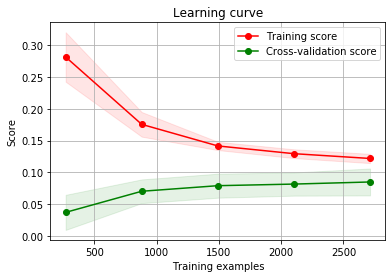

In [73]:
title = 'Learning curve'
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(xg_reg, title, X_train_std, y_train, cv=cv, n_jobs=4)

In [74]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[09:13:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [75]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.476470,0.000901,0.476607,0.000458
1,0.456114,0.001594,0.456286,0.001067
2,0.438538,0.002163,0.438937,0.001776
3,0.423927,0.002645,0.424532,0.002382
4,0.411273,0.002660,0.412264,0.003599


In [76]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.3463
Name: test-rmse-mean, dtype: float64


In [77]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[09:13:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [78]:
# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

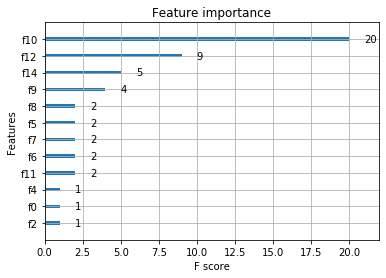

In [79]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## Ensembles

In [80]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

In [81]:
m = KNeighborsClassifier(n_neighbors=3)
bag = BaggingClassifier(
    m, 
    max_samples=.5, 
    max_features=6, 
    n_jobs=5,
    oob_score=True)
bag.fit(X_train_std, y_train)

bag.oob_score_
bag.score(X_train_std, y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.8549528301886793

In [82]:
adab = AdaBoostClassifier(base_estimator=None, n_estimators=100)
adab.fit(X_train_std, y_train)
adab.score(X_train_std, y_train)

0.8614386792452831

In [83]:
m = VotingClassifier(
    estimators=[('Kneigh', KNeighborsClassifier()), 
                ('AdaBoost', AdaBoostClassifier()), 
                ('RandomForest', RandomForestClassifier())], 
    voting='hard')

In [84]:
m.fit(X_train_std, y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier(estimators=[('Kneigh',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('AdaBoost',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.0,
                                                 n_estimators=50,
                                                 random_state=None)),
                             ('RandomForest',
                              RandomForestClassifier(bootstra...
                               

In [85]:
m.score(X_train_std, y_train)

0.8844339622641509

### Calibrated probabilities

In [95]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.svm import SVC
from matplotlib import pyplot

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

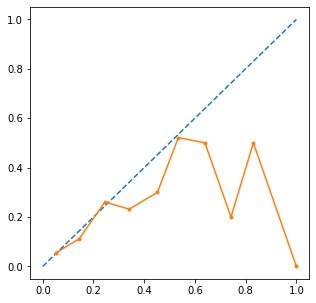

In [91]:
# Using Random Forest Classifier from above
rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
calibrated = CalibratedClassifierCV(rf, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)
predictions_y_6_calibrated = calibrated.predict_proba(X_test)[:, 1]
fop, mpv = calibration_curve(y_test, predictions_y_6_calibrated, n_bins=10, normalize=True)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [105]:
# Calibrated and uncalibrated together
def uncalibrated(X_train, X_test, y_train):
    rf = SVC()
    rf.fit(X_train, y_train)
    return rf.decision_function(X_test)

def calibrated(X_train, X_test, y_train):
    rf = SVC()
    calibrated = CalibratedClassifierCV(rf, method='sigmoid', cv=5)
    calibrated.fit(X_train, y_train)
    return calibrated.predict_proba(X_test)[:, 1]

yhat_uncalibrated = uncalibrated(X_train, X_test, y_train)
yhat_calibrated = calibrated(X_train, X_test, y_train)

fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, yhat_uncalibrated, n_bins=7, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, yhat_calibrated, n_bins=7)


C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C

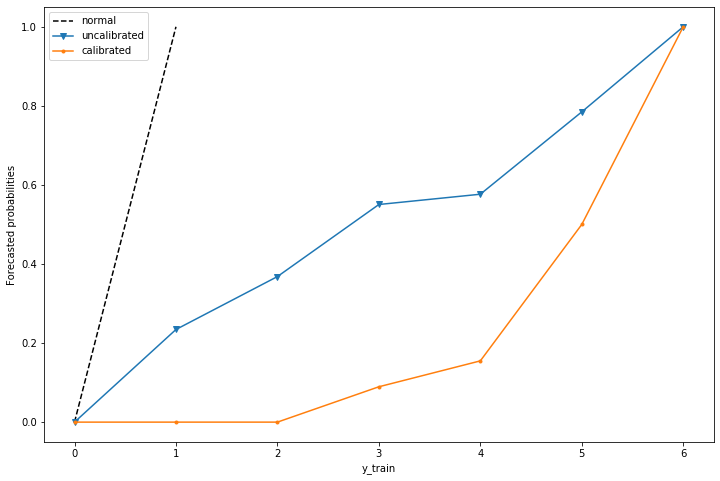

In [109]:
plt.figure(figsize=(12,8))
pyplot.plot([0, 1], [0, 1], linestyle='--', color='black', label = 'normal')
pyplot.plot(mpv_uncalibrated, label = 'uncalibrated', marker = 'v')
pyplot.plot(fop_uncalibrated, label = 'calibrated', marker = '.')
pyplot.xlabel("y_train")
pyplot.ylabel("Forecasted probabilities")
pyplot.legend(loc='upper left')
pyplot.show()